In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def apply_motion_blur(image, size=15):
    """Creates a motion blur kernel and applies it to the image."""
    kernel = np.zeros((size, size))
    kernel[int((size - 1) / 2), :] = np.ones(size)
    kernel = kernel / size
    blurred = cv2.filter2D(image, -1, kernel, borderType=cv2.BORDER_REPLICATE)
    return blurred, kernel

In [3]:
def wiener_filter(blurred, kernel, K=0.01):
    """
    Restores a blurred image using Wiener filtering in the frequency domain.

    Args:
        blurred: Blurred input image (2D array).
        kernel: Blur kernel (2D array).
        K: Constant representing noise-to-signal power ratio (tune for best results).

    Returns:
        Restored image (2D array, uint8).
    """
    # Pad kernel to match image size
    kh, kw = kernel.shape
    ih, iw = blurred.shape
    kernel_padded = np.zeros_like(blurred, dtype=np.float32)
    kernel_padded[:kh, :kw] = kernel

    # FFT
    dft_blurred = np.fft.fft2(blurred)
    dft_kernel = np.fft.fft2(kernel_padded)

    # Avoid division by zero
    dft_kernel_conj = np.conj(dft_kernel)
    denom = (np.abs(dft_kernel) ** 2) + K
    wiener = dft_kernel_conj / denom

    # Apply Wiener filter
    dft_restored = wiener * dft_blurred
    restored = np.fft.ifft2(dft_restored)
    restored = np.abs(restored)

    # Normalize and convert to uint8
    restored = np.clip(restored, 0, 255).astype('uint8')
    return restored

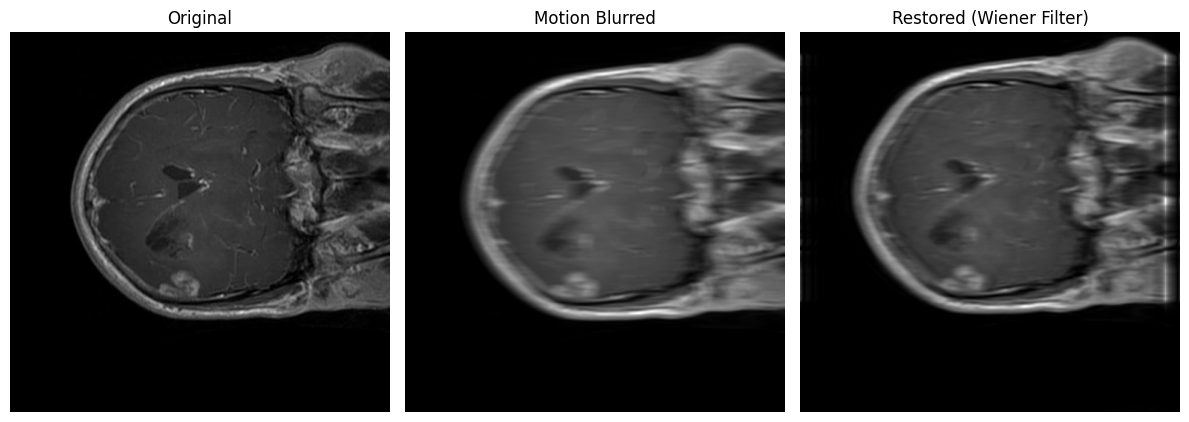

In [21]:
# Load and prepare image
image = cv2.imread('../samples/brain_glioma_0004.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Image not found! Check path.")

blurred, psf = apply_motion_blur(image, size=20)
restored = wiener_filter(blurred, psf, K=0.1)  # K=0.001, 0.01, 0.1, ...

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Motion Blurred")
plt.imshow(blurred, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Restored (Wiener Filter)")
plt.imshow(restored, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()